In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import math
from scipy.stats import multivariate_normal
import seaborn as sns
np.random.seed(2024)

# TP4 : Improve the Metropolis-Hastings algorithm

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

#### Question 1 and question 2

In [72]:
# First initialize the parameters
def initialize_parameters(power = 5):
    # Initialize the parameters
    a = 10
    sigma_x = 3
    sigma_y = 3
    n_sample = 10 ** power
    return a, sigma_x, sigma_y, n_sample

a, sigma_x, sigma_y, n_sample = initialize_parameters()

# -------------------------------------- #

# Define the target distribution and the proposal kernels
def target_distribution(x, y, a):
    """ Target distribution pi(x, y) """
    return np.exp( - (x ** 2 / a ** 2) - y ** 2 - (((x ** 2 / a ** 2) - y ** 2) ** 2) / 4)

def proposal_kernel_x(x, y, sigma_x):
    """ Proposal kernel P1 """
    x_prime = np.random.normal(x, sigma_x)
    y_prime = y
    return x_prime, y_prime

def proposal_kernel_y(x, y, sigma_y):
    """ Proposal kernel P2 """
    x_prime = x
    y_prime = np.random.normal(y, sigma_y)
    return x_prime, y_prime

# -------------------------------------- #
def samples_P(x0, y0, a, sigma_x, sigma_y, n_sample, burnin = 0):
    """ Implement an algorithm which samples a chain with kernel P"""
    samples = list()
    samples.append([x0, y0])
    acceptance_x = 0
    acceptance_y = 0

    for _ in tqdm(range(n_sample)):
        x, y = samples[-1]
        p = np.random.random()
        q = np.random.random()
        if p <= 0.5:    # Update X
            x_prime, y_prime = proposal_kernel_x(x, y, sigma_x)
            alpha = min(1, target_distribution(x_prime, y_prime, a) / target_distribution(x, y, a))
            if q < alpha:    # We accept the sample
                samples.append([x_prime, y_prime])
                acceptance_x += 1
            else:
                samples.append([x, y])
        else:    # Update Y
            x_prime, y_prime = proposal_kernel_y(x, y, sigma_y)
            alpha = min(1, target_distribution(x_prime, y_prime, a) / target_distribution(x, y, a))
            if q < alpha:
                samples.append([x_prime, y_prime])
                acceptance_y += 1
            else:
                samples.append([x, y])
    samples = np.array(samples[burnin:])
    print(f"Acceptance rate for X: {acceptance_x / n_sample}, with sigma_x = {sigma_x}")
    print(f"Acceptance rate for Y: {acceptance_y / n_sample}, with sigma_y = {sigma_y}")
    return np.array(samples), acceptance_x / n_sample, acceptance_y / n_sample

# -------------------------------------- #

100%|██████████| 100000/100000 [00:00<00:00, 415239.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Acceptance rate for X: 0.42884, with sigma_x = 3
Acceptance rate for Y: 0.12719, with sigma_y = 3


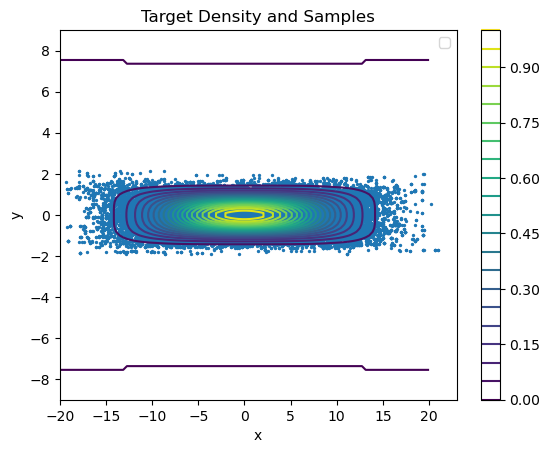

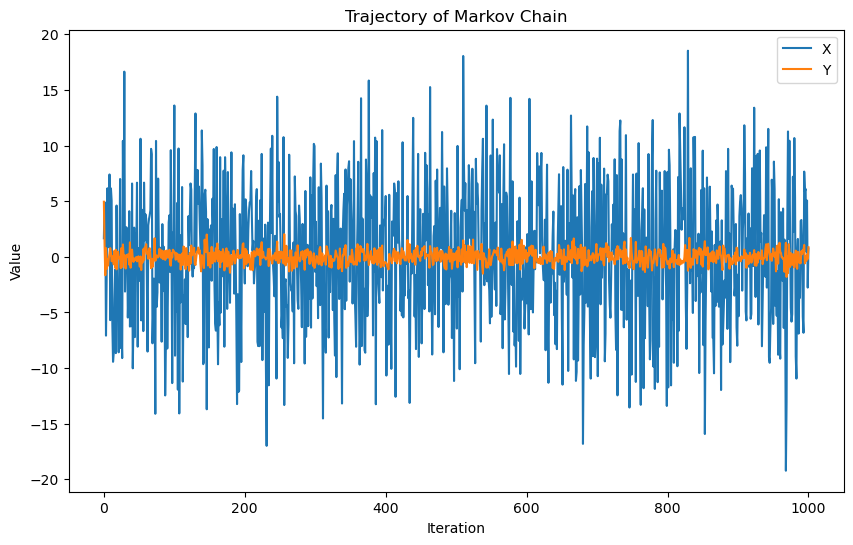

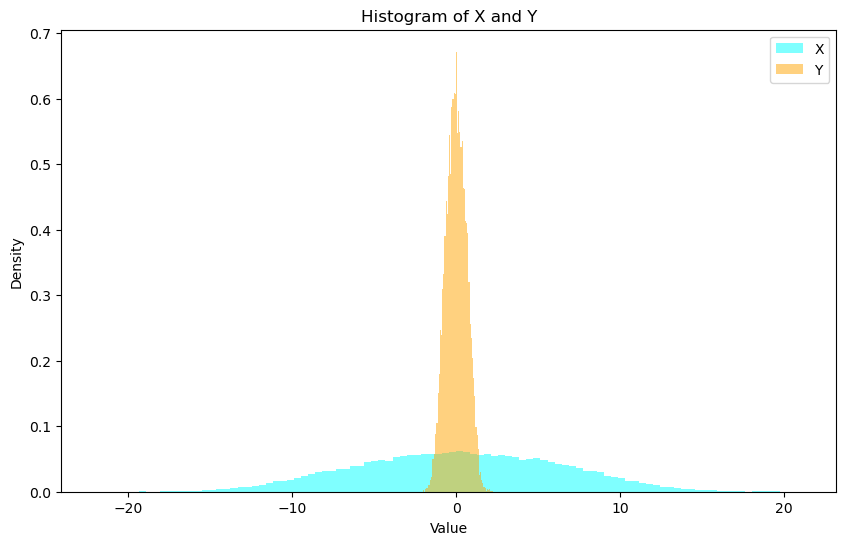

(0.0, 200.0)

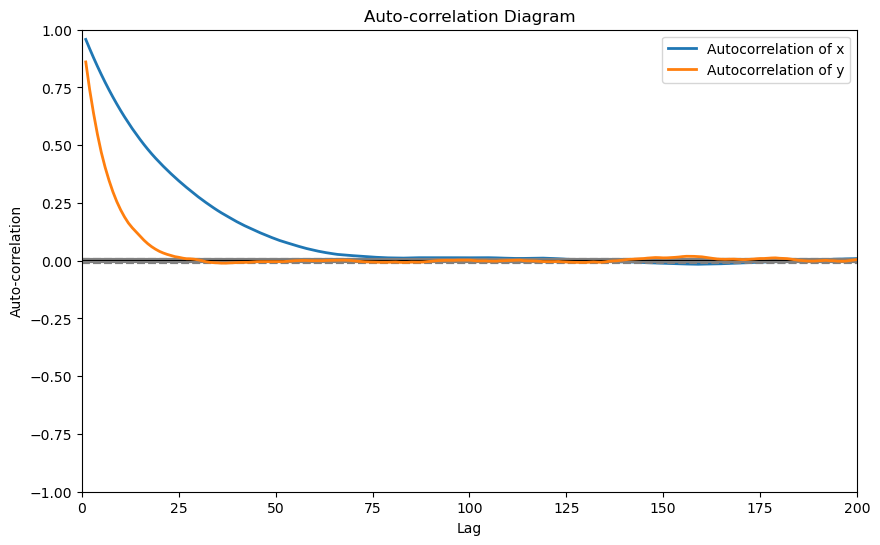

In [73]:
# Generate samples from the target distribution
x0, y0 = np.random.uniform(-a, a), np.random.uniform(-a, a)
samples, _, _ = samples_P(x0, y0, a, sigma_x, sigma_y, n_sample)
X, Y = samples[:, 0], samples[:, 1]

n_burnin = n_sample // 5
X_burnin, Y_burnin = X[n_burnin:], Y[n_burnin:]
plot_offset_x = np.max(X_burnin) // 2
plot_offset_y = np.max(Y_burnin) // 2
x_range = np.linspace(-a - plot_offset_x, a + plot_offset_x, 100)
y_range = np.linspace(-a + plot_offset_y, a - plot_offset_y, 100)
x, y = np.meshgrid(x_range, y_range)
z = target_distribution(x, y, a)

contour = plt.contour(x, y, z, cmap = 'viridis', levels = 20)
plt.scatter(samples[n_burnin:, 0], samples[n_burnin:, 1], s = 2)
plt.title('Target Density and Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour)

plt.figure(figsize = (10, 6))
plt.plot(X[::100], label = 'X')
plt.plot(Y[::100], label = 'Y')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.figure(figsize = (10, 6))
plt.hist(X, bins = 100, density = True, alpha = 0.5, color = "cyan", label = "X")
plt.hist(Y, bins = 100, density = True, alpha = 0.5, color = "orange", label = "Y")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of X and Y")
plt.legend()
plt.show()

plt.figure(figsize = (10, 6))
pd.plotting.autocorrelation_plot(X, label = 'Autocorrelation of x', linewidth = 2)
pd.plotting.autocorrelation_plot(Y, label = 'Autocorrelation of y', linewidth = 2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,200))

In this situation, the algorithm is not efficient.

The acceptance rate for $x$ stays too high, it might be due to the fact that $ \sigma _1 $ is too small.

#### Question 3

First, we could try different values of $ \sigma $ in order to have good acceptance rates.
Second, incorporing burn-in will improve the performance of our MCMC algorithm by ensuring that the chain has reached its stationary distribution before collecting samples for inference. 

100%|██████████| 100000/100000 [00:00<00:00, 338376.12it/s]


Acceptance rate for X: 0.49588, with sigma_x = 0.1
Acceptance rate for Y: 0.47792, with sigma_y = 0.1


100%|██████████| 100000/100000 [00:00<00:00, 443414.23it/s]


Acceptance rate for X: 0.46567, with sigma_x = 1.5
Acceptance rate for Y: 0.22771, with sigma_y = 1.5


100%|██████████| 100000/100000 [00:00<00:00, 363854.85it/s]


Acceptance rate for X: 0.4507, with sigma_x = 2
Acceptance rate for Y: 0.18354, with sigma_y = 2


100%|██████████| 100000/100000 [00:00<00:00, 345273.86it/s]


Acceptance rate for X: 0.44185, with sigma_x = 2.5
Acceptance rate for Y: 0.15363, with sigma_y = 2.5


100%|██████████| 100000/100000 [00:00<00:00, 462309.62it/s]


Acceptance rate for X: 0.42845, with sigma_x = 3
Acceptance rate for Y: 0.1285, with sigma_y = 3


100%|██████████| 100000/100000 [00:00<00:00, 357510.63it/s]


Acceptance rate for X: 0.38562, with sigma_x = 5
Acceptance rate for Y: 0.07938, with sigma_y = 5


100%|██████████| 100000/100000 [00:00<00:00, 362031.72it/s]


Acceptance rate for X: 0.29381, with sigma_x = 10
Acceptance rate for Y: 0.04073, with sigma_y = 10


100%|██████████| 100000/100000 [00:00<00:00, 362214.30it/s]


Acceptance rate for X: 0.22708, with sigma_x = 15
Acceptance rate for Y: 0.02762, with sigma_y = 15


100%|██████████| 100000/100000 [00:00<00:00, 471298.18it/s]


Acceptance rate for X: 0.18468, with sigma_x = 20
Acceptance rate for Y: 0.0205, with sigma_y = 20


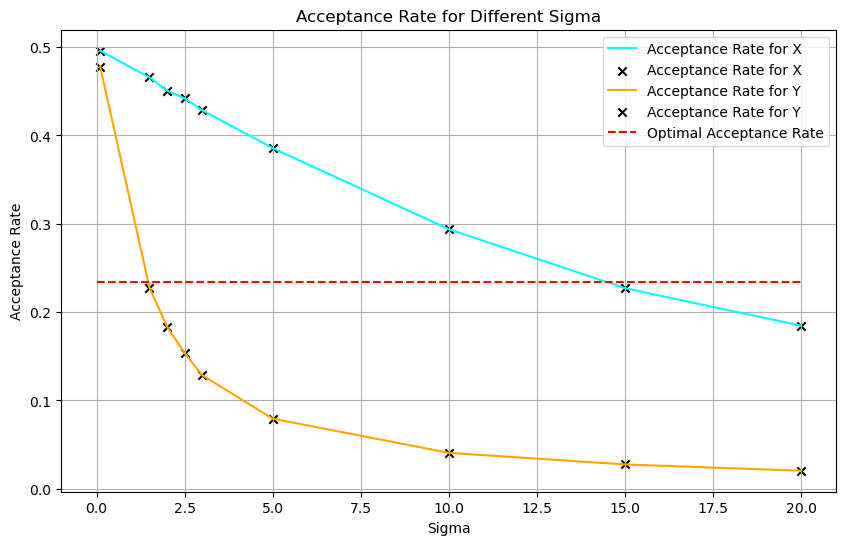

In [46]:
SIGMAS = [0.1, 1.5, 2, 2.5, 3, 5, 10, 15, 20]
acceptance_rates = list()
for sigma in SIGMAS:
    _, acceptance_x, acceptance_y = samples_P(x0, y0, a, sigma, sigma, n_sample)
    acceptance_rates.append([acceptance_x, acceptance_y])

acceptance_rates = np.array(acceptance_rates)
plt.figure(figsize = (10, 6))
plt.plot(SIGMAS, acceptance_rates[:, 0], label = 'Acceptance Rate for X', color = 'cyan')
plt.scatter(SIGMAS, acceptance_rates[:, 0], label = 'Acceptance Rate for X', color = 'black', marker = 'x')
plt.plot(SIGMAS, acceptance_rates[:, 1], label = 'Acceptance Rate for Y', color = "orange")
plt.scatter(SIGMAS, acceptance_rates[:, 1], label = 'Acceptance Rate for Y', color = 'black', marker = 'x')
plt.hlines(0.234, 0, 20, color = 'red', linestyle='--' ,label = 'Optimal Acceptance Rate')
plt.xlabel('Sigma')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate for Different Sigma')
plt.legend()
plt.grid()
plt.show()

From this, we deduce that optimal values for $\sigma _x $ (resp. $\sigma _y $) are  $\sigma _x = 14 $ (resp. $\sigma _y = 1.4$).

100%|██████████| 100000/100000 [00:00<00:00, 327970.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Acceptance rate for X: 0.23915, with sigma_x = 14
Acceptance rate for Y: 0.23946, with sigma_y = 1.4


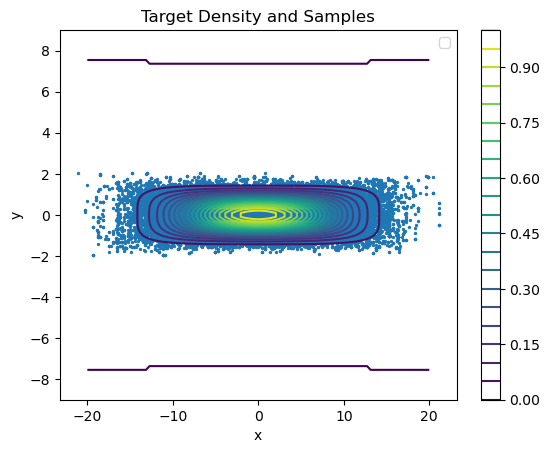

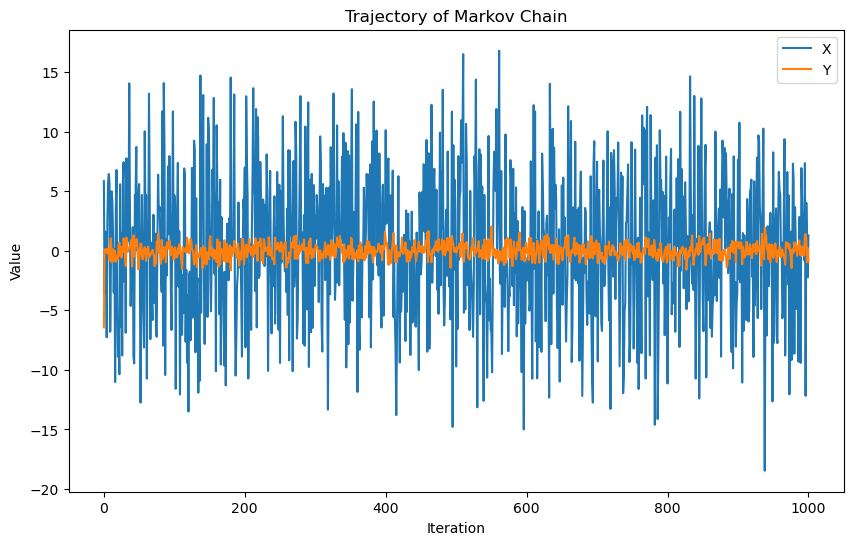

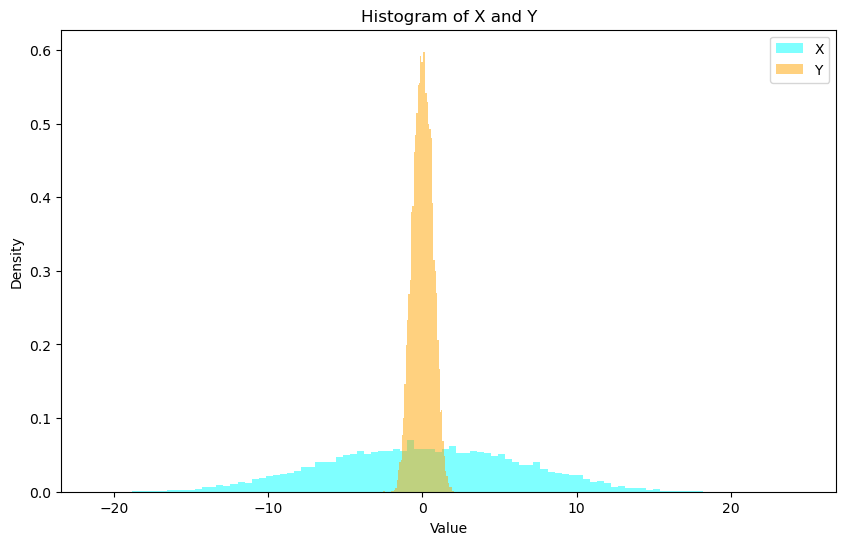

(0.0, 200.0)

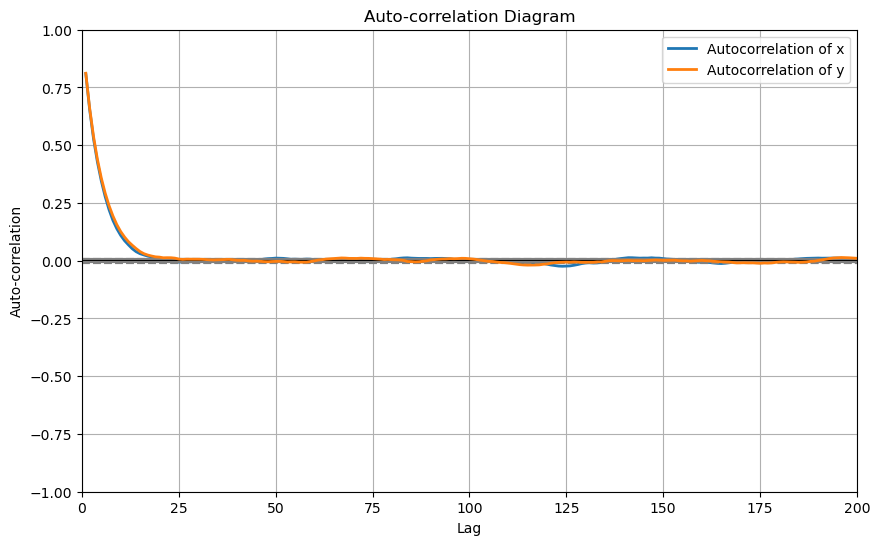

In [59]:
sigma_x = 14
sigma_y = 1.4
samples, _, _ = samples_P(x0, y0, a, sigma_x, sigma_y, n_sample)
X, Y = samples[:, 0], samples[:, 1]

n_burnin = n_sample // 5
X_burnin, Y_burnin = X[n_burnin:], Y[n_burnin:]
plot_offset_x = np.max(X_burnin) // 2
plot_offset_y = np.max(Y_burnin) // 2
x_range = np.linspace(-a - plot_offset_x, a + plot_offset_x, 100)
y_range = np.linspace(-a + plot_offset_y, a - plot_offset_y, 100)
x, y = np.meshgrid(x_range, y_range)
z = target_distribution(x, y, a)

contour = plt.contour(x, y, z, cmap = 'viridis', levels = 20)
plt.scatter(samples[n_burnin:, 0], samples[n_burnin:, 1], s = 2)
plt.title('Target Density and Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour)

plt.figure(figsize = (10, 6))
plt.plot(X[::100], label = 'X')
plt.plot(Y[::100], label = 'Y')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.figure(figsize = (10, 6))
plt.hist(X, bins = 100, density = True, alpha = 0.5, color = "cyan", label = "X")
plt.hist(Y, bins = 100, density = True, alpha = 0.5, color = "orange", label = "Y")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of X and Y")
plt.legend()
plt.show()

plt.figure(figsize = (10, 6))
pd.plotting.autocorrelation_plot(X, label = 'Autocorrelation of x', linewidth = 2)
pd.plotting.autocorrelation_plot(Y, label = 'Autocorrelation of y', linewidth = 2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.grid()
plt.xlim((0,200))

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

#### Algorithm 1: Metropolis-Hastings (symmetric random walk) within Gibbs Sampler

##### **Initialize the state**
$x_k = \left[x_k[1], ..., x_k[d] \right]$

##### **Proposal step**
$ x^* \sim \mathcal{N} (x_k, \sigma ^2) $ 

##### **Gibbs Sampling**
for i in range(1, d+1):

    # Sample using Metropolis-Hastings

$ x_{k+1}[i] \sim \pi (x_i | x_{k+1} [1], ..., x_{k+1} [i-1], x_k[i+1], ..., x_k[d])$

**END**

#### Question 1:

In [101]:
def MH_within_GS(x0, y0, a, sigma_x0, sigma_y0, n_sample, burnin = 0):
    samples = list()
    samples.append([x0, y0])
    acceptance_x = []
    acceptance_x_mean = []
    acceptance_y = []
    acceptance_y_mean = []
    sigma_x = sigma_x0
    sigma_y = sigma_y0

    for step in tqdm(range(1, n_sample)):
        x, y = samples[-1]
        p = np.random.random()
        q = np.random.random()

        x_proposed, y_proposed = proposal_kernel_x(x, y, sigma_x)
        alpha = min(1, target_distribution(x_proposed, y_proposed, a) / target_distribution(x, y, a))
        if p < alpha:
            x, y = x_proposed, y_proposed
            samples.append([x, y])
            acceptance_x.append(1)
        else:
            samples.append([x, y])
            acceptance_x.append(0)
        
        x_proposed, y_proposed = proposal_kernel_y(x, y, sigma_y)
        alpha = min(1, target_distribution(x_proposed, y_proposed, a) / target_distribution(x, y, a))
        if q < alpha:
            samples.append([x_proposed, y_proposed])
            acceptance_y.append(1)
        else:
            samples.append([x, y])
            acceptance_y.append(0)
        
        j = step // 50
        if j > 0 and step % 50 == 0:
            delta=min(
                    0.01, 
                    1 / np.sqrt(j)
                    )
            current_acceptance_x = sum(acceptance_x[-50:]) / (50)
            acceptance_x_mean.append(current_acceptance_x)
            current_acceptance_y = sum(acceptance_y[-50:]) / (50)
            acceptance_y_mean.append(current_acceptance_y)
            if current_acceptance_x > 0.234:
                sigma_x = np.exp(
                                np.log(
                                    sigma_x
                                    ) + delta)
            else:
                sigma_x = np.exp(
                                np.log(
                                    sigma_x
                                    ) - delta)
            if current_acceptance_y > 0.234:
                sigma_y = np.exp(
                                np.log(
                                    sigma_y
                                    ) + delta)
            else:
                sigma_y = np.exp(
                                np.log(
                                    sigma_y
                                    ) - delta)
    samples = np.array(samples[burnin:])
    print(f"Acceptance rate for X: {np.mean(acceptance_x)}")
    print(f"Acceptance rate for Y: {np.mean(acceptance_y)}")
    print(f"Final sigma_x: {sigma_x}")
    print(f"Final sigma_y: {sigma_y}")
    return np.array(samples), sigma_x, sigma_y, acceptance_x_mean, acceptance_y_mean

In [106]:
burnin = 0
a, sigma_x, sigma_y, n_sample = initialize_parameters(power = 4)
x0, y0 = np.random.uniform(-a, a), np.random.uniform(-a, a)
samples, sigma_x, sigma_y, acceptance_x_mean, acceptance_y_mean = MH_within_GS(x0, y0, a, sigma_x, sigma_y, n_sample, burnin = burnin)

100%|██████████| 9999/9999 [00:00<00:00, 161508.24it/s]

Acceptance rate for X: 0.6299629962996299
Acceptance rate for Y: 0.23622362236223624
Final sigma_x: 21.08606274176743
Final sigma_y: 3.48550272818485


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


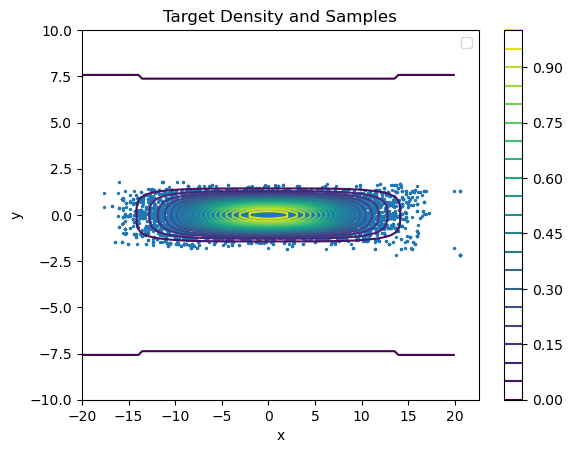

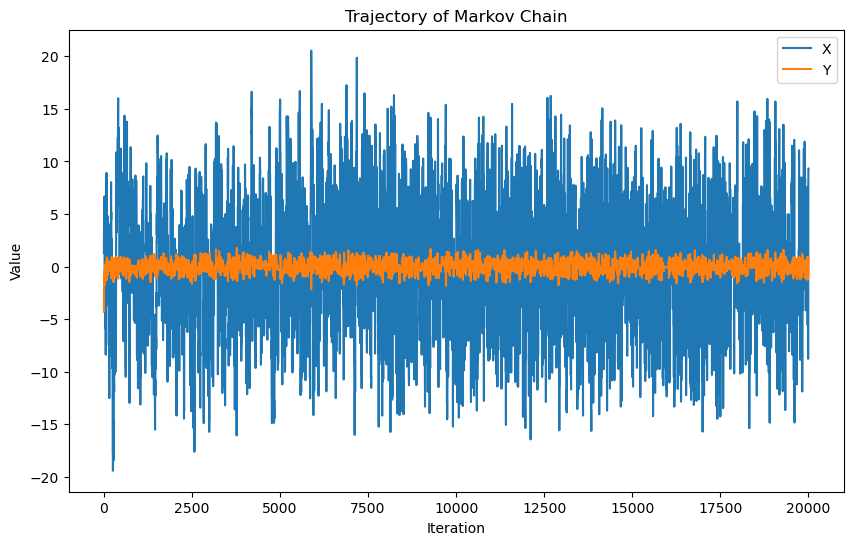

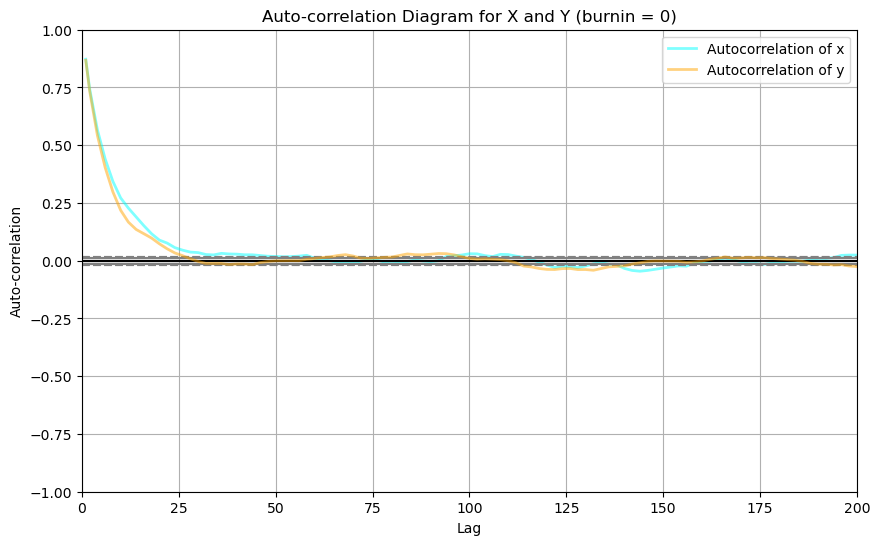

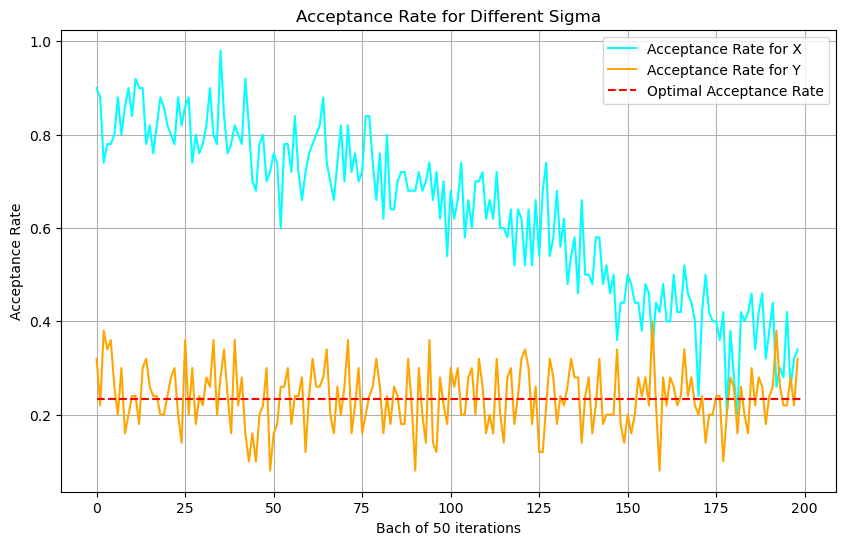

In [107]:
X, Y = samples[:, 0], samples[:, 1]

n_burnin = n_sample // 5
X_burnin, Y_burnin = X[n_burnin:], Y[n_burnin:]
plot_offset_x = np.max(X_burnin) // 2
plot_offset_y = np.max(Y_burnin) // 2
x_range = np.linspace(-a - plot_offset_x, a + plot_offset_x, 100)
y_range = np.linspace(-a + plot_offset_y, a - plot_offset_y, 100)
x, y = np.meshgrid(x_range, y_range)
z = target_distribution(x, y, a)

contour = plt.contour(x, y, z, cmap = 'viridis', levels = 20)
plt.scatter(samples[n_burnin:, 0], samples[n_burnin:, 1], s = 2)
plt.title('Target Density and Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour)

plt.figure(figsize = (10, 6))
plt.plot(X, label = 'X')
plt.plot(Y, label = 'Y')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.figure(figsize = (10, 6))
pd.plotting.autocorrelation_plot(X, label = f'Autocorrelation of x', linewidth = 2, alpha = 0.5, color = 'cyan')
pd.plotting.autocorrelation_plot(Y, label = f'Autocorrelation of y', linewidth = 2, alpha = 0.5, color = 'orange')
plt.title(f'Auto-correlation Diagram for X and Y (burnin = {burnin})')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.grid()
plt.xlim((0,200))

plt.figure(figsize = (10, 6))
plt.plot(acceptance_x_mean, label = 'Acceptance Rate for X', color = 'cyan')
plt.plot(acceptance_y_mean, label = 'Acceptance Rate for Y', color = 'orange')
plt.hlines(0.234, 0, len(acceptance_x_mean), color = 'red', linestyle='--' ,label = 'Optimal Acceptance Rate')
plt.xlabel('Bach of 50 iterations')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate for Different Sigma')
plt.legend()
plt.grid()
plt.show()

## Exercise 2

### 2.A – A toy example

$$ \forall x \in \mathbb{R}^2, \quad \pi(x) = \displaystyle \sum _{i=1} ^{20} \frac{w_i}{2 \pi \sigma _i ^2} \text{exp} \left( - \frac{1}{2 \sigma _i ^2} (x - \mu _i)^T  (x - \mu _i)\right)$$

#### Question 1

In [228]:
MU = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],
               [3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],
               [5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],
               [4.93,1.50],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])
sigmas = 0.1 * np.ones(20)
wis = 0.05 * np.ones(20)

def gaussian_mixture(x, mus, sigmas, wis):
    """ Target distribution
    Parameters:
    -----------
    mus: list
        List of means
    sigmas: list
        List of standard deviations
    wis: list
        List of weights
    
    Returns:
    --------
    float
        Value of the target distribution at x = (x1, x2)
    """
    if len(x) != 2:
        raise ValueError("The input must be a 2D point")
    
    if len(mus) != len(sigmas) or len(sigmas) != len(wis):
        raise ValueError("The length of the input lists must be the same")
    
    return sum([(wi / (2 * math.pi * sigma)) * 
                np.exp(- (np.inner((x - mu), (x - mu)) / (2 * sigma ** 2)))
                for mu, sigma, wi in zip(mus, sigmas, wis)])

def HM_sampler(x0, pi, sigma_prop, MUS, sigmas, wis, max_iter = 10 ** 4, verbose = True, tqdm = True):
    """ Hastings-Metropolis sampler
    Parameters:
    -----------
    x0: np.array
        Initial point
    pi: function
        Target distribution
    sigma_prop: float
        Proposal standard deviation
    max_iter: int
        Maximum number of iterations

    Returns:
    --------
    sample: np.array
        Samples from the target distribution
    """
    dimension = len(x0)
    if sigma_prop.shape[0] != dimension:
        raise ValueError("The proposal standard deviation must have the same dimension as the input")
    
    sample = [x0]
    acceptance_rates = []
    if tqdm:
        for _ in tqdm(range(1, max_iter)):
            x = sample[-1]
            x_prop = x + np.random.normal(np.zeros(dimension), sigma_prop, dimension)
            alpha = min(1, pi(x_prop, MUS, sigmas, wis) / pi(x, MUS, sigmas, wis))
            u = np.random.random()
            if u < alpha:
                sample.append(x_prop)
                acceptance_rates.append(1)
            else:
                sample.append(x)
                acceptance_rates.append(0)
    else:
        for _ in range(1, max_iter):
            x = sample[-1]
            x_prop = x + np.random.normal(np.zeros(dimension), sigma_prop, dimension)
            alpha = min(1, pi(x_prop, MUS, sigmas, wis) / pi(x, MUS, sigmas, wis))
            u = np.random.random()
            if u < alpha:
                sample.append(x_prop)
                acceptance_rates.append(1)
            else:
                sample.append(x)
                acceptance_rates.append(0)
    if verbose:
        print(f"Acceptance rate: {np.mean(acceptance_rates)}, with sigma = {sigma_prop}")
    return np.array(sample)

#### Question 2

In [227]:
x0 = np.random.randn(2)
sigma_prop = 0.35 * np.ones(2)
samples = HM_sampler(x0, gaussian_mixture, sigma_prop, MU, sigmas, wis, verbose = True)

100%|██████████| 9999/9999 [00:00<00:00, 11699.29it/s]

Acceptance rate: 0.23802380238023801, with sigma = [0.35 0.35]


Good acceptance rate !

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_5003/2980398822.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Contours of $\pi$, the target distribution vs MH samples")


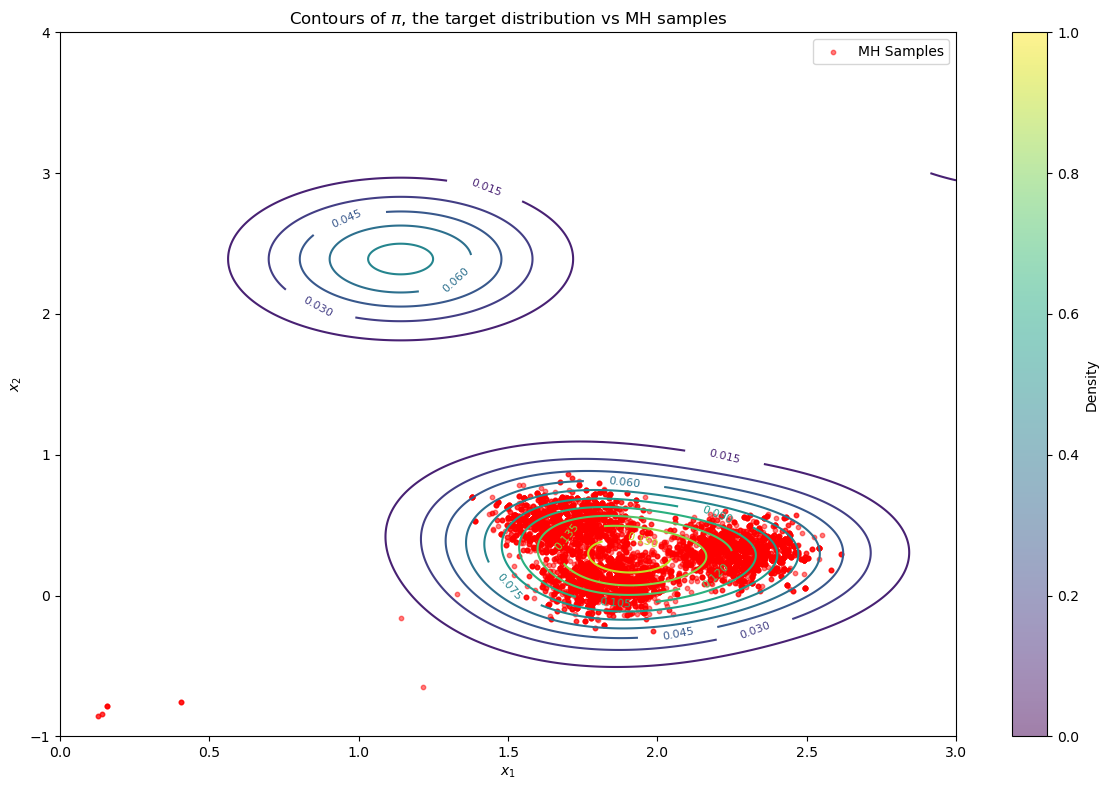

In [165]:
x = np.linspace(-3, 3, 10 ** 3)  
y = np.linspace(-3, 3, 10 ** 3)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.zeros(X.shape)
for w, mu, sigma in zip(wis, MU, sigmas):
    rv = multivariate_normal(mean = mu, cov = sigma * np.eye(2))
    Z += w * rv.pdf(pos) 

# Tracé des contours
plt.figure(figsize=(12, 8))
contour_target = plt.contour(X, Y, Z, levels = 10, cmap = 'viridis')
plt.clabel(contour_target, inline=True, fontsize=8)
plt.scatter(samples[:, 0], samples[:, 1], s=10, c='red', alpha=0.5, label='MH Samples')
plt.title("Contours of $\pi$, the target distribution vs MH samples")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar(label="Density")
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.xlim(0, 3)
plt.ylim(-1, 4)
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_5003/3061160553.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Contours of $\pi$, the target distribution vs MH samples")


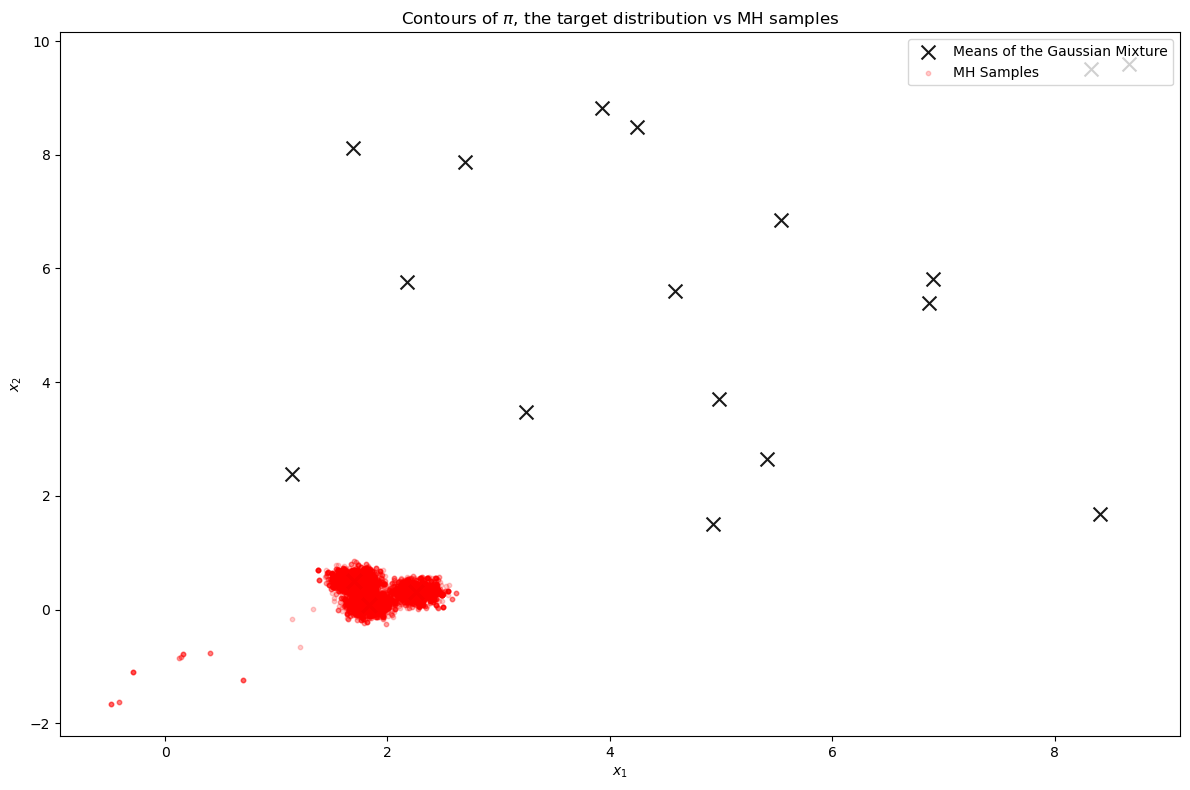

In [171]:
plt.figure(figsize=(12, 8))
plt.scatter(MU[:, 0], MU[:, 1], s = 100, label = 'Means of the Gaussian Mixture', marker = 'x', alpha = 0.9, color = 'black')
plt.scatter(samples[:, 0], samples[:, 1], s = 10, c = 'red', alpha = 0.2, label = 'MH Samples')
plt.title("Contours of $\pi$, the target distribution vs MH samples")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(loc = 'upper right', fontsize=10)
plt.tight_layout()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_5003/3073201205.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Contours of $\pi$, the target distribution vs MH samples (subsample)")


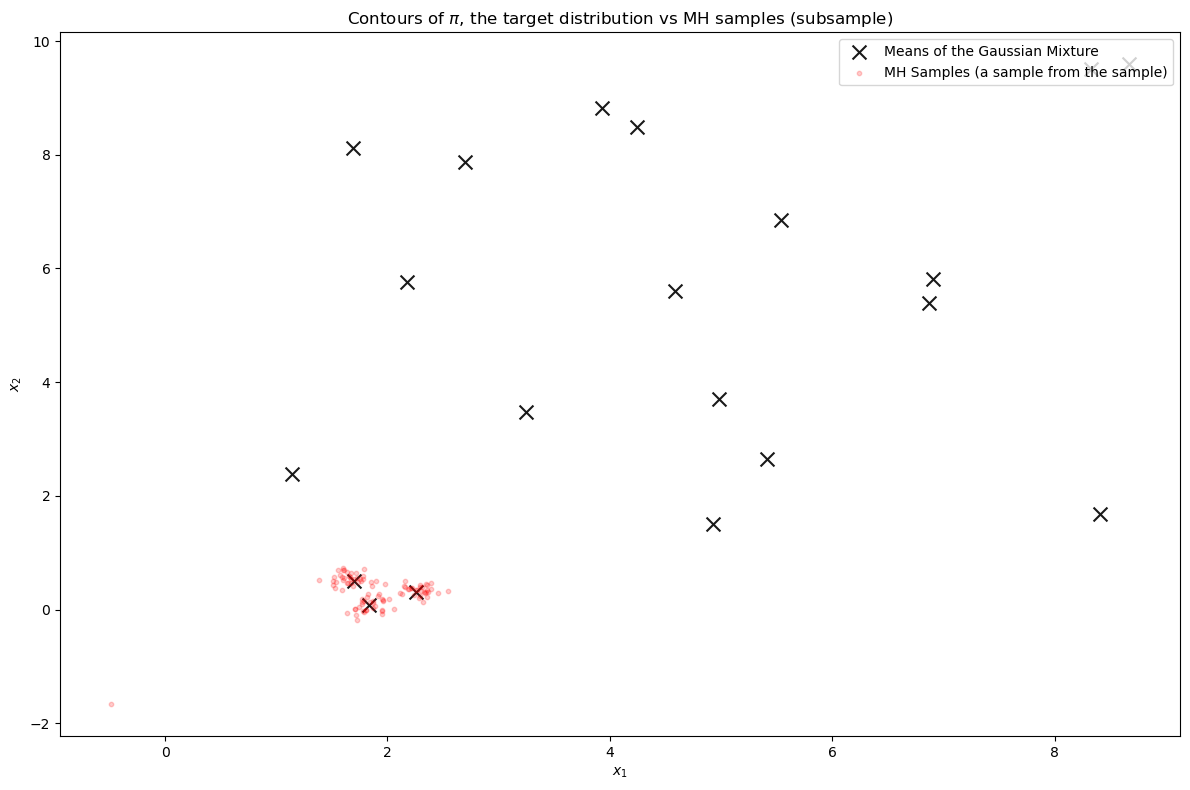

In [173]:
plt.figure(figsize=(12, 8))
plt.scatter(MU[:, 0], MU[:, 1], s = 100, label = 'Means of the Gaussian Mixture', marker = 'x', alpha = 0.9, color = 'black')
sub_samples = samples[::100]
plt.scatter(sub_samples[:, 0], sub_samples[:, 1], s = 10, c = 'red', alpha = 0.2, label = 'MH Samples (a sample from the sample)')
plt.title("Contours of $\pi$, the target distribution vs MH samples (subsample)")   
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(loc = 'upper right', fontsize=10)
plt.tight_layout()
plt.show()

We coonclude that this method is not able to sample $ \pi $ properly.

### 2.B – Parallel Tempering

#### Question 1

In [231]:
def parallel_tempering(x0, pi, T, tau, MUS, sigmas, wis, sigma_prop = 0.35 * np.ones(2), max_iter = 10 ** 4):
    """ Parallel tempering sampler
    Parameters:
    -----------
    x0: np.array
        Initial point
    pi: function
        Target distribution
    T: list
        List of temperatures
    max_iter: int
        Maximum number of iterations

    Returns:
    --------
    sample: np.array
        Samples from the target distribution
    """
    K, d = x0.shape
    if len(T) != K or len(tau) != K:
        raise ValueError("The number of temperatures must be equal to the number of chains")
    
    # Initialize the samples
    samples_K = [[list(x0[i])] for i in range(len(x0))] 

    for i in tqdm(range(1, max_iter)):
        yn = []
        for k in range(K):
            xn = samples_K[k][-1]
            y_k = HM_sampler(xn, gaussian_mixture, sigma_prop = 0.35 * np.ones(2), MUS = MUS, sigmas = sigmas, wis = wis, max_iter = 10 ** 3, verbose = False, tqdm = False)[-1]
            yn.append(y_k)
        
        # Choose chains to mix
        i,j = 0,0
        while i == j or np.abs(i-j) != 1:
            i,j = np.random.randint(0, K, size=  2)

        # Acceptance probability

        alpha = min(1, 
                ((1 / T[i]) * pi(yn[j], MUS, sigmas, wis) * 
                (1 / T[j]) * pi(yn[i], MUS, sigmas, wis)) / 
                ((1 / T[i]) * pi(yn[i], MUS, sigmas, wis) * 
                (1 / T[j]) * pi(yn[j], MUS, sigmas, wis))
        )
        
        U = np.random.random()
        if U < alpha:
            samples_K[i].append(yn[j])
            samples_K[j].append(yn[i])

        else: 
            samples_K[i].append(yn[i])
            samples_K[j].append(yn[j])

        for k in range(K):
            if k != i and k != j:
                samples_K[k].append(yn[k])

    return samples_K


In [232]:
T = np.array([60, 21.6, 7.7, 2.8, 1])
tau = [0.25 * np.sqrt(t) for t in T]
MU = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],
               [3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],
               [5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],
               [4.93,1.50],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])
sigmas = 0.1 * np.ones(20)
wis = 0.05 * np.ones(20)
x0 = np.random.randn(5, 2)
sample = parallel_tempering(x0, gaussian_mixture, T, tau, MU, sigmas, wis, sigma_prop = 0.35 * np.ones(2), max_iter = 10 ** 4)

100%|██████████| 9999/9999 [1:02:37<00:00,  2.66it/s]


<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_5003/1215224001.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Contours of $\pi$, the target distribution vs MH samples")


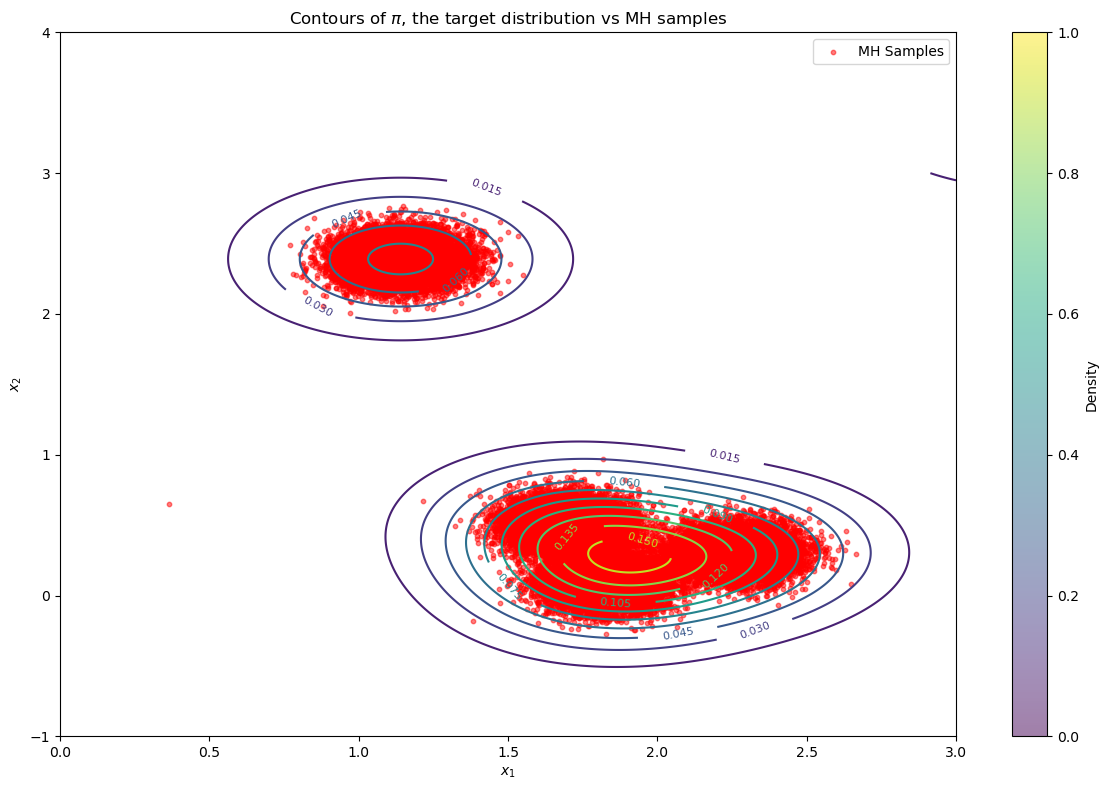

In [241]:
sample = np.array(sample)
sample = sample.reshape(-1, 2)
x = np.linspace(-3, 3, 10 ** 3)  
y = np.linspace(-3, 3, 10 ** 3)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.zeros(X.shape)
for w, mu, sigma in zip(wis, MU, sigmas):
    rv = multivariate_normal(mean = mu, cov = sigma * np.eye(2))
    Z += w * rv.pdf(pos) 

# Tracé des contours
plt.figure(figsize=(12, 8))
contour_target = plt.contour(X, Y, Z, levels = 10, cmap = 'viridis')
plt.clabel(contour_target, inline=True, fontsize=8)
plt.scatter(sample[:, 0], sample[:, 1], s=10, c='red', alpha=0.5, label='MH Samples')
plt.title("Contours of $\pi$, the target distribution vs MH samples")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar(label="Density")
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.xlim(0, 3)
plt.ylim(-1, 4)
plt.show()

In practice, the performance of the Parallel Tempering algorithm strongly depends on the choice of the temperatures ladder, the number of chains and the choice of proposal kernels. For most distribu- tions, tuning these parameters may be infeasible. In [MMV13], the authors have proposed an adaptive Parallel Tempering algorithm to address these difficulties.

## Exercise 3 : Bayesian analysis of a one-way random effects model

We recall that the density of an Inverse Gamma distribution with positive parameters $(a, b)$ is proportional to

$$x \mapsto x^{-a-1} \exp\left(-\frac{b}{x}\right) \mathbb{1}_{\mathbb{R}^+}(x),$$

and notably, we can sample $y$ from the inverse gamma distribution of parameters $(a, b)$ by generating $x$ from a gamma distribution with parameters $(a, 1)$ and then setting $y = \frac{1}{x}$. For implementation, we can directly use the \texttt{scipy.stats.invgamma} function.

Let us suppose we collect the observations $Y = \{y_{i,j}, i \in \{1, \dots, N\}, j \in \{1, \dots, k_i\}\}$ and define $k := \sum_{i=1}^N k_i$ as the total number of observations. Consider the following random effects model:

- $y_{i,j}$ is a realization of the variable $Y_{i,j}$, where $Y_{i,j} = X_i + \varepsilon_{i,j}$;

- The random effects $X = \{X_i, i \in \{1, \dots, N\}\}$ are i.i.d. from a Gaussian $\mathcal{N}(\mu, \sigma^2)$ and independent of the errors $\varepsilon = \{\varepsilon_{i,j}, i \in \{1, \dots, N\}, j \in \{1, \dots, k_i\}\}$;

- The errors $\varepsilon$ are i.i.d. from the centered Gaussian $\mathcal{N}(0, \tau^2)$;

where $(\mu, \sigma, \tau)$ are the unknown parameters.

Bayesian analysis using this model requires specifying a prior distribution. We consider:

$$\pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \propto \frac{1}{\sigma ^{2(1 + \alpha )}} \frac{1}{\tau ^{2(1 + \gamma )}} \exp\left(-\frac{\sigma^2}{1 + \alpha} - \frac{\tau^2}{\beta}\right) \mathbb{1}_{\mathbb{R}^+}(\sigma^2, \tau^2), $$

where $\alpha$, $\beta$, and $\gamma$ are known hyperparameters. 

### Question 1

 $ \begin{align} \pi_{\text{posterior}}(X , \mu, \sigma^2, \tau^2 | Y) &\propto \pi (Y | X, \mu, \sigma^2, \tau^2) \pi (X | \mu, \sigma^2, \tau^2) \pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \\ &\propto \pi (Y | X, \tau^2) \pi (X | \mu, \sigma^2) \pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \end{align} $

 - $ \pi (Y | X, \tau^2) = \displaystyle \prod _{i=1} ^N \prod _{j=1} ^{k_i} \frac{1}{\sqrt{ 2 \pi \tau ^2}} \text{exp} \left( - \frac{(Y_{i,j} - X_i )^2 }{2 \tau ^2}\right) = \displaystyle \prod _{i=1} ^N  (\frac{1}{\sqrt{ 2 \pi \tau ^2}})^{k_i} \text{exp} \left( - \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2 }{2 \tau ^2}\right) \propto (\tau ^2 )^{- \frac{k}{2}} \text{exp} \left( - \sum _{i=1} ^{N} \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2 }{2 \tau ^2}\right)$.

$\space$ 

 - $ \pi (X | \mu, \sigma^2) = \displaystyle \prod _{i=1} ^N \frac{1}{\sqrt{ 2 \pi \sigma ^2}} \text{exp} \left( - \frac{(X_i - \mu )^2 }{2 \sigma ^2}\right) \propto (\sigma ^2 )^{- \frac{N}{2}} \text{exp} \left( - \sum _{i=1} ^N \frac{(X_i - \mu )^2 }{2 \sigma ^2}\right)$

 $\space$ 

 - $ \pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \propto \displaystyle \frac{1}{ \sigma ^{2 (1 + \alpha)}} \text{exp} \left( \frac{- \beta}{\sigma ^2} \right) \frac{1}{ \tau ^{2 (1 + \gamma)}} \text{exp} \left( \frac{- \beta}{\tau ^2} \right) \mathbb{1}_{\mathbb{R}^+}(\sigma^2, \tau^2)$

 $\space $

All in all, we are able to write the density of the a posteriori distribution:

  $$ \pi_{\text{posterior}}(X , \mu, \sigma^2, \tau^2 | Y) \propto (\tau ^2 )^{- \frac{k}{2}} \text{exp} \left( - \sum _{i=1} ^{N} \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2 }{2 \tau ^2}\right) (\sigma ^2 )^{- \frac{N}{2}} \text{exp} \left( - \sum _{i=1} ^N \frac{(X_i - \mu )^2 }{2 \sigma ^2}\right) \displaystyle \frac{1}{ \sigma ^{2 (1 + \alpha)}} \text{exp} \left( \frac{- \beta}{\sigma ^2} \right) \frac{1}{ \tau ^{2 (1 + \gamma)}} \text{exp} \left( \frac{- \beta}{\tau ^2} \right) \mathbb{1}_{\mathbb{R}^+}(\sigma^2, \tau^2) $$

### Question 2

- $ \pi (X) \propto \displaystyle \prod _{i=1} ^N \text{exp} \left( - \sum _{j=1} ^{k_i} \frac{(X_i -y_{i,j})^2 }{2 \tau ^2} - \frac{(X_i - \mu )^2 }{2 \sigma ^2 } \right). \quad $ Thus, $ X_i \sim \mathcal{N} (\frac{\tau ^2 \mu + \sigma ^2 \sum _{j=1} ^{k_i} y_{i,j} }{k_i \sigma ^2 + \tau ^2 }, \frac{\tau ^2 \sigma ^2}{k_i \sigma ^2 + \tau ^2 })$.

- $ \pi (\tau ^2 ) \propto (\tau ^2 )^{- \frac{k}{2} - 2 (1 + \gamma)}   \text{exp} \left( - \sum _{i=1} ^{N} \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2 }{2 \tau ^2}\right) \text{exp} \left( \frac{- \beta}{\tau ^2} \right) \mathbb{1}_{\mathbb{R}^+}(\tau^2). \quad $ Thus, $\tau ^2 \sim \text{inv}\Gamma (\frac{k}{2} + \gamma, \beta + \sum _{i=1} ^{N} \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2}{2} ) $

- Following the same scheme, $\sigma ^2 \sim \text{inv} \Gamma (\frac{k}{2} + \alpha, \beta + \sum _{i=1} ^{N} \sum _{j=1} ^{k_i} \frac{(Y_{i,j} - X_i )^2}{2} ) $

- Finally, $ \mu \sim \mathcal{N} (\frac{1}{N} \sum _{i=1} ^N X_i , \frac{\sigma ^2}{N})$

We can implement a Gibbs sampler:

In [95]:
def Gibbs_sampler(Y, N, k, tau0, sigma0, mu0, X0, alpha, beta, gamma, max_iter = 10 ** 4):
    """ Gibbs sampler 
    Parameters:
    -----------
    Y: np.array
        Data matrix
    N: int
        Number of indivuduals
    k: list
        number of features for each sample
    tau0: float
        Prior 
    sigma0: float
        Prior 
    mu0: float
        Prior 
    X0: np.array
        Initial value of the latent variables
    alpha, gamma, beta: float
        Hyperparameters
    max_iter: int
        Maximum number of iterations
    
    Returns:
    --------
    X, sigma, tau, mu: np.array
        Samples from the target distribution
    """
    X_list, X = [X0], X0
    sigma_list, sigma = [sigma0], sigma0
    tau_list, tau = [tau0], tau0
    mu_list, mu = [mu0], mu0
    K = np.sum(k)

    for _ in tqdm(range(1, max_iter)):
        tau_prop = np.random.gamma(shape = N / 2 + alpha , scale = 1 / ( beta + np.sum((X - mu) ** 2) / 2))
        sigma_prop = np.random.gamma(shape = K / 2 + gamma, scale = 1 / (1 / beta + np.sum((X - mu) ** 2) / 2))
        mu_prop = np.random.normal(loc = np.mean(X), scale = np.sqrt(sigma / N))

        X_prop = []
        for i in range(N):
            mean = (tau * mu + sigma * np.sum(Y[i, :])) / (k[i] * sigma + tau)
            var = (tau * sigma) / (k[i] * sigma + tau)
            X_prop.append(np.random.normal(loc = mu_prop, scale = np.sqrt(tau_prop)))
        X_prop = np.array(X_prop)

        tau_list.append(tau_prop)
        sigma_list.append(sigma_prop)
        mu_list.append(mu_prop)
        X_list.append(X_prop)
        tau = tau_prop
        sigma = sigma_prop
        mu = mu_prop
        X = X_prop

    # Discard burn-in samples
    discard = max_iter // 5
    sigma_list = sigma_list[int(discard):]
    tau_list = tau_list[int(discard):]
    mu_list = mu_list[int(discard):]
    X_list = X_list[int(discard):]
    
    
    return np.array(sigma_list), np.array(tau_list), np.array(mu_list), np.array(X_list)


### Question 3

$ \begin{align}
P(X, \mu \mid Y, \sigma^2, \tau^2) 
&\propto \prod_{i=1}^N \exp\left(-\frac{\sum_{j=1}^{k_i} (y_{i,j} - X_i)^2}{2\tau^2} - \frac{(X_i - \mu)^2}{2\sigma^2}\right) \\
&\propto \prod_{i=1}^N \exp\left(-\frac{1}{2} \left( \frac{\sigma^2 k_i + \tau^2}{\tau^2 \sigma^2} X_i^2 - \frac{2 \sum_{j=1}^{k_i} y_{i,j} X_i}{\tau^2} - \frac{2 X_i \mu}{\sigma^2} + \frac{\mu^2}{\sigma^2} \right)\right)
\end{align} $

Thus, if we consider:


$$ \text{Cov} = 
\begin{pmatrix}
\frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & 0 & \cdots & \frac{-1}{\sigma^2} \\
0 & \ddots & \cdots & \vdots \\
0 & 0 & \frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & \frac{-1}{\sigma^2} \\
\frac{-1}{\sigma^2} & \cdots & \frac{-1}{\sigma^2} & \frac{N}{\sigma^2}
\end{pmatrix}
$$

and 

$$
\mathbf{\mu} = \text{Cov} . 
\begin{pmatrix}
\frac{\sum_{j=1}^{k_1} y_{1,j}}{\tau^2} & \cdots & \frac{\sum_{j=1}^{k_N} y_{N,j}}{\tau^2}
\end{pmatrix},
$$

we have: $ (X, \mu) \sim \mathcal{N}(\mathbf{\mu}, \text{Cov})$.

In [81]:
def block_Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , max_iter = 10 ** 4, burnin = 0.25):
    """ Block Gibbs sampler 
    Parameters:
    -----------
    Y: np.array
        Data matrix
    sigma0: float
        Prior
    tau0: float
        Prior
    mu0: float
        Prior
    X0: np.array
        Initial value of the latent variables
    alpha, gamma, beta: float
        Hyperparameters
    N: int
        Number of individuals
    k: list
        Number of features for each sample
    num_samples: int
        Number of samples to draw
    burnin: float
        Burnin ratio
    
    Returns:
    --------
    X, sigma, tau, mu: np.array
        Samples from the target distribution
    """
    X_list, X = [X0], X0
    sigma_list, sigma = [sigma0], sigma0
    tau_list, tau = [tau0], tau0
    mu_list, mu = [mu0], mu0
    K = np.sum(k)

    for _ in tqdm(range(1, max_iter)):
        tau_prop = np.random.gamma(shape = N / 2 + alpha , scale = 1 / ( beta + np.sum((X - mu) ** 2) / 2))
        sigma_prop = np.random.gamma(shape = K / 2 + gamma, scale = 1 / (1 / beta + np.sum((X - mu) ** 2) / 2))

        cov = np.zeros((N+1, N+1))
        diag_idx = np.diag_indices(N+1)
        cov[diag_idx] = (K * sigma + tau) / (sigma * tau)
        cov[:,N]= -1 / sigma
        cov[N,:] = -1 / sigma
        cov[N,N] = N / sigma

        Y_ = np.array([np.sum(Y[i, :]) for i in range(N)] + [mu_list[-1]])
        mean = np.dot(cov, (Y_ / tau))

        prop = np.random.multivariate_normal(mean = mean, cov = np.linalg.pinv(cov), size = 1).reshape(N+1)
        X_prop = prop[:N]
        mu_prop = prop[-1]

        tau_list.append(tau_prop)
        sigma_list.append(sigma_prop)
        mu_list.append(mu_prop)
        X_list.append(X_prop)
        tau = tau_prop
        sigma = sigma_prop
        mu = mu_prop
        X = X_prop

    # Discard burn-in samples
    discard = burnin * max_iter
    sigma_list = sigma_list[int(discard):]
    tau_list = tau_list[int(discard):]
    mu_list = mu_list[int(discard):]
    X_list = X_list[int(discard):]
    
    
    return np.array(sigma_list), np.array(tau_list), np.array(mu_list), np.array(X_list)

The Block Gibbs sampler is often preferred over the standard Gibbs sampler in certain scenarios. First, when the number of variables is large, sampling each variable individually can become computationally expensive. Grouping variables into blocks and sampling them jointly can significantly improve efficiency. Second, when variables exhibit strong correlations, sequentially sampling them one at a time can result in poor chain mixing and high autocorrelation. By sampling correlated variables together in blocks, the chain's mixing behavior can be enhanced, leading to better convergence properties.

### Question 5

In [107]:
# Target values
N = 10 ** 3
d = 5
alpha = 0.25
beta = 0.25
gamma = 0.25
k = [d] * N
mu_true = 5.
sigma_true = 2.5
tau_true = 1.75

# Initial values
mu0 = 2.5
sigma0 = 1.1
tau0 = 1.1
X0 = np.random.normal(mu0, sigma0, N)

# Generate data 
X = np.random.normal(mu_true, sigma_true, N)
eps = np.random.normal(0, tau_true, (N, 5))
Y = np.array([X[i] + eps[i] for i in range(N)])

In [108]:
sigma_list, tau_list, mu_list, X_list = Gibbs_sampler(Y, N, k, tau0, sigma0, mu0, X0, alpha, beta, gamma, max_iter = 10 ** 4)

100%|██████████| 9999/9999 [00:20<00:00, 487.71it/s]


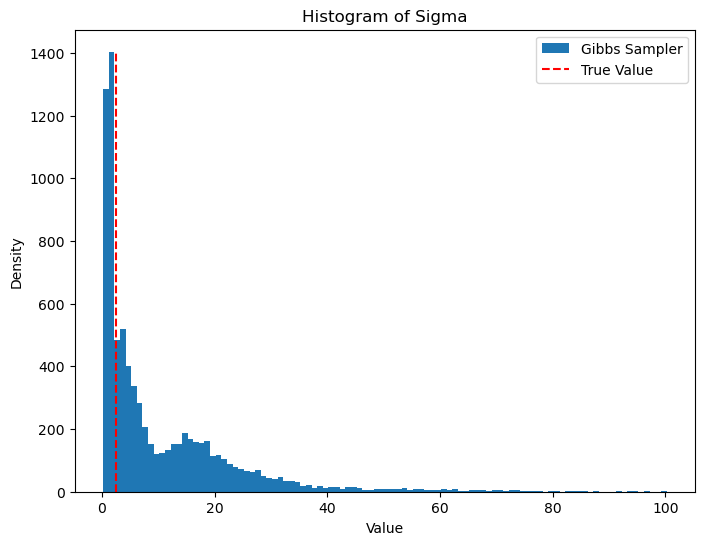

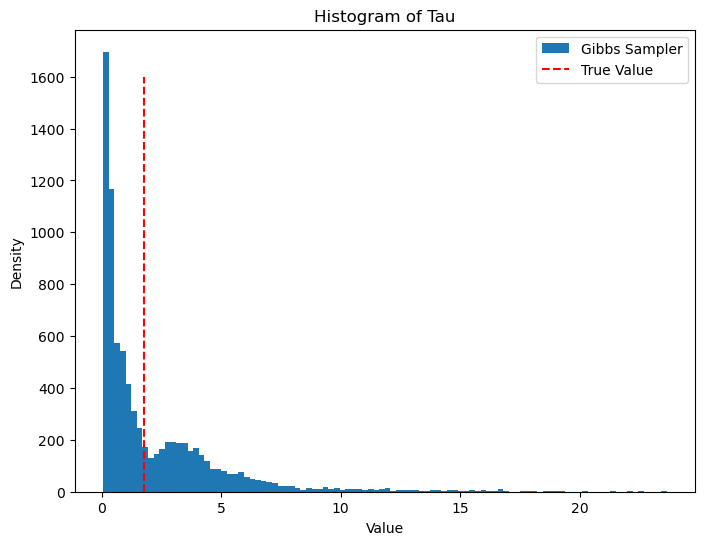

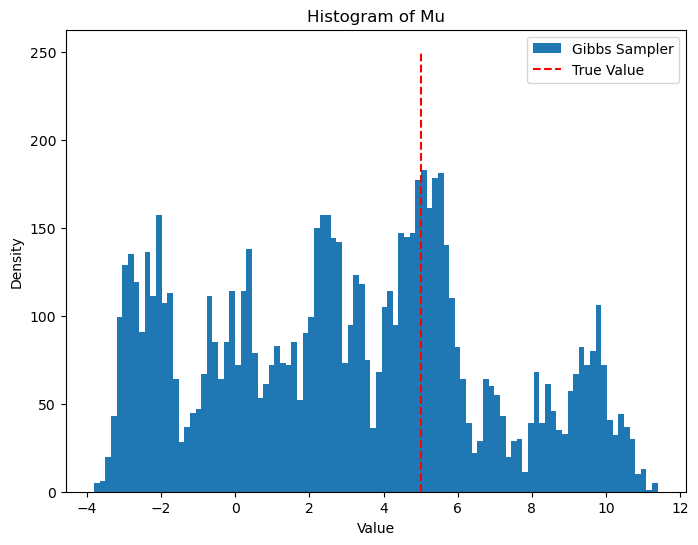

In [109]:
plt.figure(figsize = (8, 6))
plt.hist(sigma_list, bins = 100, density = False, label = "Gibbs Sampler")
#plt.hist(sigma_list_b, bins = 100, density = True, alpha = 0.25, color = "orange", label = "Block Gibbs Sampler")
plt.vlines(sigma_true, 0, 1400, color = "red", linestyle = "--", label = "True Value")
plt.title("Histogram of Sigma")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
plt.hist(tau_list, bins = 100, density = False, label = "Gibbs Sampler")
#plt.hist(tau_list_b, bins = 100, density = True, alpha = 0.25, color = "orange", label = "Block Gibbs Sampler")
plt.vlines(tau_true, 0, 1600, color = "red", linestyle = "--", label = "True Value")
plt.title("Histogram of Tau")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
plt.hist(mu_list, bins = 100, density = False, label = "Gibbs Sampler")
#plt.hist(mu_list_b, bins = 100, density = True, alpha = 0.25, color = "orange", label = "Block Gibbs Sampler")
plt.vlines(mu_true, 0, 250, color = "red", linestyle = "--", label = "True Value")
plt.title("Histogram of Mu")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

After several experiments, it becomes clear that the choice of initial parameters is crucial...